# Natural Language Processing on Google Reviews
***
**Google** is frequently used for hunting restaurants. The customers will look for reviews and ratings to pick their eating location. People will write about positive words like *“good taste”*, *“perfect service”*, and *“nice vibe”* and give higher star score when they really enjoy the place. In contrast, when people have bad experiences, they will also provide negative feedback with lower scores. However, the Google rating trend is not always clear and straightforward. When the customers do not have extreme feelings, they tend to give a middle score without any reviews. It does not directly translate into the restaurant's good or bad performance. Reviews represent direct feedback from the customer, which in most business is consider as a key driver of changes and worth like gold. In this project we want to assess the power of **NLP**, **Sentiment Analysis** and **Machine Learning** to apply **Predictive Analytics** to such a business area.

***
## Project Set-Up
> - Importing all the **required libraries** for this project.

In [1]:
import pandas as pd
import numpy as np
import spacy
import yake
import nltk
import re
pd.options.mode.chained_assignment = None

## PRE-PROCESSING
> ***
> ### Data Cleaning 
> Now that the data is ready, it is time to clean it. From **text cleaning** to **formatting** all variable all the dataset will be cleaned below. For this project, we decided to follow the trend of the litterature on web reviews classification by transforming our terget interval variable to a **binary target variable** where 4 and and 5 stars would be classified as an event, a good review and the rest as a bad review.

In [17]:
'READING DATA'
df_reviews = pd.read_csv("data/df_reviews.csv")

'TREATING MISSING VALUES'
# Keep only reviews with text
df_reviews = df_reviews[~pd.isnull(df_reviews['Review Text'])]
df_reviews.reset_index(inplace = True)
df_reviews = df_reviews.drop(['index', 'Unnamed: 0'], axis = 1)

In [18]:
'TARGET VARIABLE DEFINITION'
# Define variabes format
df_reviews['Review Rate'] = df_reviews['Review Rate'].str[:2]
df_reviews['Review Rate'] = df_reviews['Review Rate'].astype(int)

# Transform the interval target into a binary target
df_reviews.loc[df_reviews['Review Rate'] <= 3, 'Y'] = int(0)
df_reviews.loc[df_reviews['Review Rate'] > 3, 'Y'] = int(1) 
df_reviews['Y'] = df_reviews['Y'].astype(int)

'REVIEW TIME CLEANING'
# Replace the Indefinite articles "a " by "1 "
df_reviews["Review Time"] = df_reviews["Review Time"].str.replace("a ","1 ")

# Clean the code "\n" - Paragraphs format does not matter
df_reviews["Review Time"] = df_reviews["Review Time"].str.replace("\n"," ")

# Convert all the times to weeks - For future time-series analysis
for i in range(0, len(df_reviews["Review Time"])):
    if df_reviews["Review Time"][i].split(" ")[1][0] == "d":
        df_reviews["Review Time"][i] = 0
    elif df_reviews["Review Time"][i].split(" ")[1][0] == "w":
        df_reviews["Review Time"][i] = int(df_reviews["Review Time"][i].split(" ")[0]) 
    elif df_reviews["Review Time"][i].split(" ")[1][0] == "m":
        df_reviews["Review Time"][i] = round(int(df_reviews["Review Time"][i].split(" ")[0]) * 4.35)
    elif df_reviews["Review Time"][i].split(" ")[1][0] == "y":
        df_reviews["Review Time"][i] = round(int(df_reviews["Review Time"][i].split(" ")[0]) * 52.18)

> ***
> ### NLP Process
>The challenge in a Natural Language Processing (NLP) project is to make the models properly to deal with text data. The two common steps performed in similar projects that extend beyond data cleaning are **stop words removal** and **stemming**. The stop words removal consists in getting rid of all the words that do not bring any value to the text information and more importantly the words that do not carry any sort of “sentiment” information. The stemming, consist in classifying all the words of a same group within a same word, for example “Opening”, “Opens”, “Opened” etc., will be stemmed and recognize as “Open” in each case. These simplification steps are meant to keep the essential information of a text while *simplifying the data* to increase model’s performances.

In [19]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

'REVIEW TEXT CLEANING'
for i in range(len(df_reviews['Review Text'])):
    
    'CLEANING'
    review = re.sub('[^a-zA-Z]', ' ', str(df_reviews['Review Text'][i])) 
    
    'CASING'
    review = review.lower()
    
    'REPLACEMENT'
    review = review.replace('translated by google','')
    
    'ENCODING'
    review = review.encode('ascii',errors='ignore').decode('ascii')
    
    'STOPWORDS'
    word_tokens = word_tokenize(review)
    review = [w for w in word_tokens if not w in stop_words]
    review = ' '.join(review)
    
    'STEMMING'
    review = ps.stem(review)
    
    df_reviews['Review Text'][i] = review

## NLP Modelling
> On top of stemming and getting rid of the stop words, a common technique used in this type of project with large amount of data is called the **"bag-of-word"**. The idea is to leverage on the famous NLP field of **keyword-extraction** to focus on the keywords that will serve our purpose. We used three different pre-trained keywords extraction models in Python, respectively called: *SpaCy*, *Yake*, and *RakeNtlk*. One of the key parameters in keyword extraction task is N, knew to be the maximum number of words to be present in any extracted string. “Love” is therefore a Unigram where N = 1, “Love You” would be a Bigram where N = 2 and “I Love You Very Much” would be a 5-Gram where N = 5. 
>
> ***
> ### BAG-OF-WORDS
> For this project, mainly for performance reasons we chose to focus on **Unigram and Bigram** by having Nmax = 2. Knowing that there are no rules such as “the higher the Nmax the  better” and that finding the optimal Nmax tradeoff is actually an entire field of research. As a piece of information, using these easy parameters, creating the bag-of-words for our 35k reviews already needs almost 5 minutes of computation time and contains 52,323 strings.

In [20]:
'KEYWORD-EXTRACTION MODELS'
# SPACY
from collections import Counter
from string import punctuation
nlp = spacy.load("en_core_web_sm")

# RAKE-NLTK
from rake_nltk import Rake
rake_nltk_var = Rake(min_length=1, max_length=2)

# YAKE
kw_extractor = yake.KeywordExtractor()
language = "en"
max_ngram_size = 2
deduplication_threshold = 0.9
nb_keywords = 5
custom_kw_extractor = yake.KeywordExtractor(lan=language, 
                                            n=max_ngram_size, 
                                            dedupLim=deduplication_threshold, 
                                            top=nb_keywords, 
                                            features=None)

In [21]:
'KEYWORD-EXTRACTION FUNCTIONS'
def get_hotwords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN']
    doc = nlp(text.lower())
    for token in doc:
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            result.append(token.text)     
    return result

def get_KW(Review_Text,KW):
    #spacy
    doc = nlp(Review_Text)
    keywords_spacy = set(x[0] for x in Counter(set(get_hotwords(Review_Text))).most_common(5))
    for kw in keywords_spacy:
        KW.append(kw)
    #yake
    extract = custom_kw_extractor.extract_keywords(Review_Text)
    for kw in extract:
        KW.append(kw[0].replace(" ",""))
    #rake_nltk
    rake_nltk_var.extract_keywords_from_text(Review_Text)
    keyword_extracted = rake_nltk_var.get_ranked_phrases()
    for kw in keyword_extracted:
        KW.append(kw.replace(" ",""))
    return(KW)

In [22]:
'BAG-OF-WORD GENERATION'
BOW = []
for i in range(len(df_reviews)):
    KW = []
    get_KW(df_reviews.loc[i,"Review Text"],KW)
    KW = set(KW)
    KW = ' '.join(KW)
    BOW.append(KW)

print(BOW[:20])

['delicious mi banh friendlyservice best weekend servicedelicious deliciousfood comingback townfriendly', 'awesomesuper refin superrefin awesome super', 'people sandwich nice goodseee taste peoplework goodseepeople worknice bringlots niceyah', 'decentsandwich decent sandwich lik', 'nice mi banh lady solidbanh runsnice niceadd solid ladyruns addextra', 'sandwich mi packedseparately banh amountmeat separatelyamount veggies veggiespacked noteveggies meat', 'bahn best mi pho', 'tasty lunch lunchwarm warmbroths checkcash staffappeared ph attitudestaff vietnamese owners', 'mi banh spot school favourite schoolbanh favouritespot', 'servicecompetitively efficientservice competitivelypriced efficient pricedfood food service', 'delicious favorite restaurantsauthentic absolute soupcombo vietnameserestaurants authentichome owners timeabsolute authentic', 'tasti', 'enjoyedlady delici place lady placedelici ranplace ladyran', 'goodvalu bahmi best fresh freshgood bahmichinatown valu chinatownfresh goo

> ***
> ### VECTORIZATION
> A challenge with NLP is that, when there is no numerical data, mathematics does not apply. But most machine learning models rely on mathematical principles. This is where Vectorization steps in. The idea is to transform the relation between our data
(reviews) and our bag of words into vectors. There are multiple vectorization techniques, but one of the simplest, most efficient and commonly used is the **Count-Vectorize** option (Frequency based). This consists simply in counting for each review how many times each instance of the bag-of-word appear into a review and to store this into a **sparse matrix**.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
nlp_data_vectorized = vectorizer.fit_transform(BOW)
vectorizer.get_feature_names()

def print_vectors(X):
    print('Shape of Sparse Matrix: ', nlp_data_vectorized.shape)
    print('Amount of Non-Zero occurrences: ', nlp_data_vectorized.nnz)# Percentage of non-zero values
    density = (100.0 * nlp_data_vectorized.nnz / (nlp_data_vectorized.shape[0] * nlp_data_vectorized.shape[1]))
    print('Density: {}'.format((density)))

print_vectors(nlp_data_vectorized)

Shape of Sparse Matrix:  (21048, 52323)
Amount of Non-Zero occurrences:  171503
Density: 0.015572855342243676


***
## Data Partitionning
> When predicting a **binary target** it is important to ensure that the sample used to train and validate models reflects the inital population's parameters proportion. A well known statistical method to overcome this issue is called **stratified sampling**.

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(nlp_data_vectorized, 
                                                    df_reviews['Y'].tolist(), 
                                                    test_size=0.3, 
                                                    random_state=101,
                                                    stratify = df_reviews['Y'])

***
## Predictive Models
> The models we decided to include in our analyses are **Naïve bayes**, **Neural Networks**, **K-nearest
neighbor**, and **Random Forest Classifier**.
> ***
> ### Training
> - Models have been trained with there default parameters. A **Hyperparameter optimization** excercise would lead to better results.
> - Expect the **Neural Net** and the **Random Forest Classifier** to require quite some time for training.

In [30]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb_obj = nb.fit(X_train, y_train)

In [32]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)
mlp_obj = mlp.fit(X_train, y_train)

Minimum error:- 0.18954869358669835 at K = 3


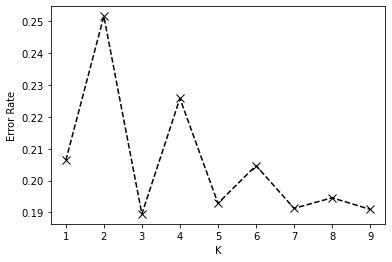

In [92]:
from sklearn.neighbors import KNeighborsClassifier
error_rate = []
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(6,4))
plt.plot(range(1,10),error_rate,color='black', linestyle='dashed', marker='x',markerfacecolor='blue', markersize=8)
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

In [68]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn_obj = knn.fit(X_train, y_train)

In [33]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc_obj = rfc.fit(X_train, y_train)

> ***
> ### Prediction
>
> When it comes to assess a model that predicts a binary target or events, the idea of **threshold** steps in. All models will produce **probabilities** as an output. It is up to the user to define above which theshold a prediction will be considered as a 1 (e.g. as an **event**). In this case threshold have been **manually fine tuned** for each model based on specifitiy.

In [51]:
preds_nb = (nb.predict_proba(X_test)[:,1] >= 0.75).astype(bool)

In [35]:
preds_mlp = (mlp.predict_proba(X_test)[:,1] >= 0.7).astype(bool)

In [75]:
preds_knn = (knn.predict_proba(X_test)[:,1] >= 0.6).astype(bool)

In [61]:
preds_rfc = (rfc.predict_proba(X_test)[:,1] >= 0.75).astype(bool)

> ***
> ### Assessment
>
> - We are going to focus on **Confusion Matrices** and **ROC Curves** to assess the models' performance.

In [46]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']

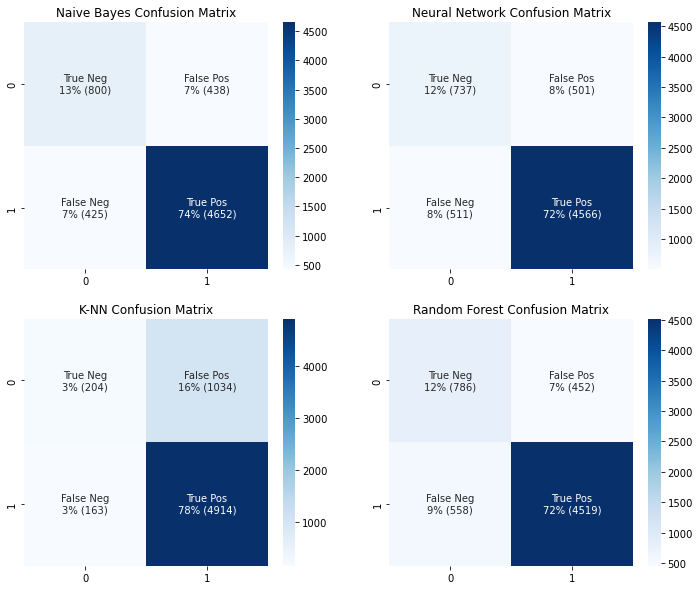

In [76]:
#Plot size parameters
plt.figure(figsize=(12,10))

#Generate Confusion Matrices
cf_matrix_nb = confusion_matrix(y_test, preds_nb)
cf_matrix_mlp = confusion_matrix(y_test, preds_mlp)
cf_matrix_knn = confusion_matrix(y_test, preds_knn)
cf_matrix_rfc = confusion_matrix(y_test, preds_rfc)

group_counts_nb = ["{0:0.0f}".format(value) for value in cf_matrix_nb.flatten()]
group_counts_mlp = ["{0:0.0f}".format(value) for value in cf_matrix_mlp.flatten()]
group_counts_knn = ["{0:0.0f}".format(value) for value in cf_matrix_knn.flatten()]
group_counts_rfc = ["{0:0.0f}".format(value) for value in cf_matrix_rfc.flatten()]

group_percentages_nb = ["{0:.0%}".format(value) for value in cf_matrix_nb.flatten()/np.sum(cf_matrix_nb)]
group_percentages_mlp = ["{0:.0%}".format(value) for value in cf_matrix_mlp.flatten()/np.sum(cf_matrix_mlp)]
group_percentages_knn = ["{0:.0%}".format(value) for value in cf_matrix_knn.flatten()/np.sum(cf_matrix_knn)]
group_percentages_rfc = ["{0:.0%}".format(value) for value in cf_matrix_rfc.flatten()/np.sum(cf_matrix_rfc)]

labels_nb = [f"{v1}\n{v3} ({v2})" for v1, v2, v3 in zip(group_names,group_counts_nb,group_percentages_nb)]
labels_mlp = [f"{v1}\n{v3} ({v2})" for v1, v2, v3 in zip(group_names,group_counts_mlp,group_percentages_mlp)]
labels_knn = [f"{v1}\n{v3} ({v2})" for v1, v2, v3 in zip(group_names,group_counts_knn,group_percentages_knn)]
labels_rfc = [f"{v1}\n{v3} ({v2})" for v1, v2, v3 in zip(group_names,group_counts_rfc,group_percentages_rfc)]

labels_nb = np.asarray(labels_nb).reshape(2,2)
labels_mlp = np.asarray(labels_mlp).reshape(2,2)
labels_knn = np.asarray(labels_knn).reshape(2,2)
labels_rfc = np.asarray(labels_rfc).reshape(2,2)

# Subplot Naive Bayes Confusion Matrix
plt.subplot(2, 2, 1)
sns.heatmap(cf_matrix_nb, annot=labels_nb, fmt='', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')

# Subplot Neural Network Confusion Matrix
plt.subplot(2, 2, 2)
sns.heatmap(cf_matrix_mlp, annot=labels_mlp, fmt='', cmap='Blues')
plt.title('Neural Network Confusion Matrix')

# Subplot K-NN Confusion Matrix
plt.subplot(2, 2, 3)
sns.heatmap(cf_matrix_knn, annot=labels_knn, fmt='', cmap='Blues')
plt.title('K-NN Confusion Matrix')

# Subplot Random Forest Confusion Matrix
plt.subplot(2, 2, 4)
sns.heatmap(cf_matrix_rfc, annot=labels_rfc, fmt='', cmap='Blues')
plt.title('Random Forest Confusion Matrix')

plt.show()

In [77]:
import matplotlib.pyplot as plt
import scikitplot as skplt

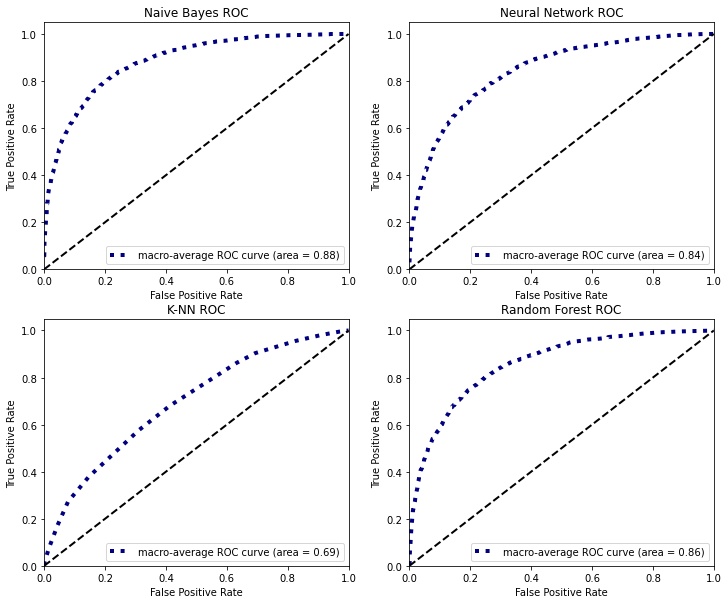

In [80]:
#Plot size parameters
plt.figure(figsize=(12,10))

#Generate ROCs
y_probas_nb = nb.predict_proba(X_test)
y_probas_mlp = mlp.predict_proba(X_test)
y_probas_knn = knn.predict_proba(X_test)
y_probas_rfc = rfc.predict_proba(X_test)

# Subplot Naive Bayes ROC
skplt.metrics.plot_roc(y_test, y_probas_nb, plot_micro=False, plot_macro=True, classes_to_plot=[], ax=plt.subplot(2, 2, 1))
plt.title('Naive Bayes ROC')

# Subplot Neural Network ROC
skplt.metrics.plot_roc(y_test, y_probas_mlp, plot_micro=False, plot_macro=True, classes_to_plot=[], ax=plt.subplot(2, 2, 2))
plt.title('Neural Network ROC')

# Subplot K-NN ROC
skplt.metrics.plot_roc(y_test, y_probas_knn, plot_micro=False, plot_macro=True, classes_to_plot=[], ax=plt.subplot(2, 2, 3))
plt.title('K-NN ROC')

# Subplot Random Forest ROC
skplt.metrics.plot_roc(y_test, y_probas_rfc, plot_micro=False, plot_macro=True, classes_to_plot=[], ax=plt.subplot(2, 2, 4))
plt.title('Random Forest ROC')

plt.show()

> ***
> ### Cluster Plot
> For the cluster plots, vectors have been **broken into two dimensions** using a TruncatedSVD decomposition to make a visual comparison on how each model classified differently the same dataset.

In [81]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

sksvd = TruncatedSVD(n_components=2)
df = sksvd.fit_transform(X_test)
col = ['#FF0000','#08306b']

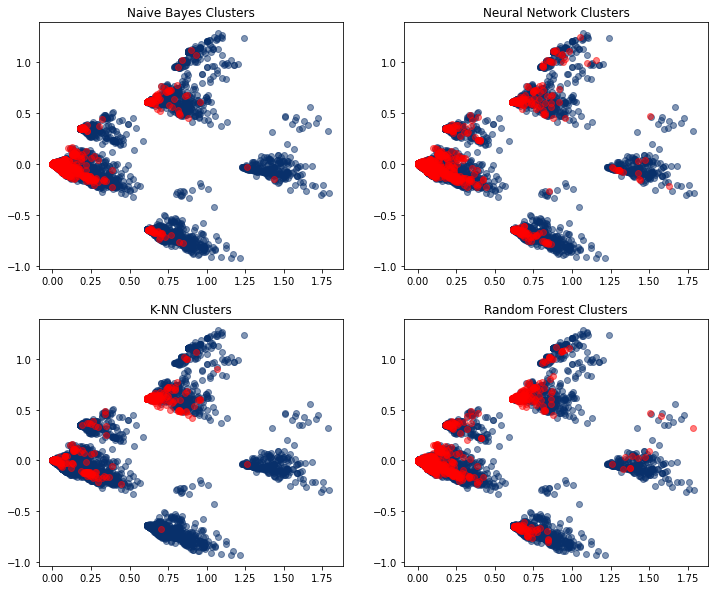

In [82]:
#Plot size parameters
plt.figure(figsize=(12,10))

label_nb = preds_nb
label_mlp = preds_mlp
label_knn = preds_knn
label_rfc = preds_rfc

u_labels_nb = np.unique(label_nb).astype(int)
u_labels_mlp = np.unique(label_mlp).astype(int)
u_labels_knn = np.unique(label_knn).astype(int)
u_labels_rfc = np.unique(label_rfc).astype(int)

# Subplot Naive Bayes SVD
plt.subplot(2, 2, 1)
for i in reversed(u_labels_nb):
    plt.scatter(df[label_nb == i , 0] , df[label_nb == i , 1] , label = i, color = col[i], alpha = 0.5)
plt.title('Naive Bayes Clusters')

# Subplot Neural Network SVD
plt.subplot(2, 2, 2)
for i in reversed(u_labels_mlp):
    plt.scatter(df[label_mlp == i , 0] , df[label_mlp == i , 1] , label = i, color = col[i], alpha = 0.5)
plt.title('Neural Network Clusters')

# Subplot K-NN SVD
plt.subplot(2, 2, 3)
for i in reversed(u_labels_knn):
    plt.scatter(df[label_knn == i , 0] , df[label_knn == i , 1] , label = i, color = col[i], alpha = 0.5)
plt.title('K-NN Clusters')

# Subplot Random Forest SVD
plt.subplot(2, 2, 4)
for i in reversed(u_labels_rfc):
    plt.scatter(df[label_rfc == i , 0] , df[label_rfc == i , 1] , label = i, color = col[i], alpha = 0.5)
plt.title('Random Forest Clusters')

plt.show()

> ***
> ### Feature Retrieval
>
> When conducting analysis using predictive modelling it might be interested to be able to **explain the model**. Regression models for example defines **coefficients** that allows human users to understand the pattern that has been found by the model. Other models like Neural Nets are known as **Black Boxe**s, and as of today, despite their amazing performance nothing can be explained about how the result was found. For this project we were able to **retrieve features** from both Naive Bayes model and Random Forest Classifier.

In [91]:
#Top words to bring back
N = 10

#PRINT_WORDS NAIVE BAYES
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()[::-1]
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()[::-1]

nb_features = pd.DataFrame(index=range(N), columns=['pos_class_words','neg_class_words'])
nb_features['pos_class_words'] = np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:N])
nb_features['neg_class_words'] = np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:N])

#PRINT_WORDS RANDOM FOREST
bow_in_model = vectorizer.get_feature_names()
importance = pd.DataFrame(rfc.feature_importances_)
top_n = importance.sort_values([0], ascending=False).head(N)

rfc_features = pd.DataFrame(index=range(N), columns=['top features'])
for i in range(N): 
    rfc_features['top features'][i] = bow_in_model[top_n.index[i]]

## SCORING
> As the NLP excercise is meant to describe **natural language** processing, one of the best way to score a model for **sentiment analysis** is to simply use our common communication knowledge to produce **manually new inputs** and see how good the models are at **predicting good or bad feelings**.
> ***
> ### Positive review assessment

In [85]:
good_review = "Amazing Banh Mi. Friendly people and tasty food, I strongly recommend."

In [86]:
'NLP PIPELINE'
str_kw_good = []
get_KW(good_review,str_kw_good)
bow_in_model = set(vectorizer.get_feature_names())
str_kw_good = [x for x in str_kw_good if x in bow_in_model]
str_kw_good = set(str_kw_good)
str_kw_good = ' '.join(str_kw_good)
kw_good = []
kw_good.append(str_kw_good)
vect_good = CountVectorizer()
x_good = vect_good.fit_transform(BOW+kw_good)

'PREDICTION'
prob_nb = nb.predict_proba(x_good[len(BOW)])
prob_nn = mlp.predict_proba(x_good[len(BOW)])
prob_knn = knn.predict_proba(x_good[len(BOW)])
prob_rfc = rfc.predict_proba(x_good[len(BOW)])

pred_nb = nb.predict(x_good[len(BOW)])
pred_nn = mlp.predict(x_good[len(BOW)])
pred_knn = knn.predict(x_good[len(BOW)])
pred_rfc = rfc.predict(x_good[len(BOW)])

print('Review Text:', good_review)
print("Good review Prob:", round(prob_nb[0][1], 2), round(prob_nn[0][1], 2),round(prob_knn[0][1], 2),round(prob_rfc[0][1], 2))
print("Good review Pred:", pred_nb, pred_nn, pred_knn, pred_rfc,'\n')

Review Text: Amazing Banh Mi. Friendly people and tasty food, I strongly recommend.
Good review Prob: 1.0 1.0 1.0 0.94
Good review Pred: [1] [1] [1] [1] 



> ***
> ### Bad review assessment

In [89]:
bad_review = "Server is rude and arrogant. Banh mi is horrible. Not worth it. Won't be back."

In [90]:
'NLP PIPELINE'
str_kw_bad = []
get_KW(bad_review,str_kw_bad)
bow_in_model = set(vectorizer.get_feature_names())
str_kw_bad = [x for x in str_kw_bad if x in bow_in_model]
str_kw_bad = set(str_kw_bad)
str_kw_bad = ' '.join(str_kw_bad)
kw_bad = []
kw_bad.append(str_kw_bad)
vect_bad = CountVectorizer()
x_bad = vect_bad.fit_transform(BOW+kw_bad)

'PREDICTION'
prob_nb = nb.predict_proba(x_bad[len(BOW)])
prob_nn = mlp.predict_proba(x_bad[len(BOW)])
prob_knn = knn.predict_proba(x_bad[len(BOW)])
prob_rfc = rfc.predict_proba(x_bad[len(BOW)])

pred_nb = nb.predict(x_bad[len(BOW)])
pred_nn = mlp.predict(x_bad[len(BOW)])
pred_knn = knn.predict(x_bad[len(BOW)])
pred_rfc = rfc.predict(x_bad[len(BOW)])

print('Review Text:', bad_review)
print("bad review Prob:", round(prob_nb[0][1], 2), round(prob_nn[0][1], 2),round(prob_knn[0][1], 2),round(prob_rfc[0][1], 2))
print("bad review Pred:", pred_nb, pred_nn, pred_knn, pred_rfc,'\n')

Review Text: Server is rude and arrogant. Banh mi is horrible. Not worth it. Won't be back.
bad review Prob: 0.17 0.0 0.67 0.05
bad review Pred: [0] [0] [1] [0] 



***